In [6]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import librosa
from librosa.core import stft,istft

#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GeForce GTX 1050


# Problem 1

## 1.1 - 1.2

In [2]:
# Fixed variables
epochs = 200               #maximum epochs of training
input_dm1 = 28             #Length of image
input_dm2 = 28             #Breadth of image
output_dm = 10             #Output dimension
early_stopping_rounds = 10  #Epochs after which training should stop if there is no increase in performance

In [3]:
#initializing transformer to convert values to tensor and normalize image matrices
trans = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.1307,), (0.3081,))
])

#Loading datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

#Reading number of samples in each set
n_train = len(mnist_train)
n_test = len(mnist_test)

# # Data loader
# train_loader = torch.utils.data.DataLoader(dataset=mnist_train, 
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=mnist_test, 
#                                            batch_size=mnist_test.data.shape[0], 
#                                            shuffle=True)

0it [00:00, ?it/s]

100%|█████████▉| 9863168/9912422 [00:33<00:00, 439467.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



0it [00:00, ?it/s]
 57%|█████▋    | 16384/28881 [00:00<00:00, 148873.96it/s]
32768it [00:00, 230153.93it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



 52%|█████▏    | 860160/1648877 [00:15<00:04, 169253.38it/s]
9920512it [00:50, 439467.25it/s]                             [A
 97%|█████████▋| 1605632/1648877 [00:23<00:00, 249458.75it/s]

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 51243.96it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
#Defining neural network class
class Network(nn.Module):
    def __init__(self,input_dm1,input_dm2,dropout=0):
        super(Network,self).__init__()
        self.input_layer = nn.Linear(input_dm1*input_dm2, 1024)
        self.hidden_layer_1 = nn.Linear(1024, 1024)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.hidden_layer_4 = nn.Linear(1024, 1024)
        self.hidden_layer_5 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 10)
        self.dd = nn.Dropout(dropout)
#         print("Neural network defined for device: "+str(device))
#         print("Input image shape: ["+str(input_dm1)+","+str(input_dm2)+"]")
        
        
    def forward(self, x):
        
        x = self.input_layer(x)
        x = F.relu(x)
        #x = self.dd(x)
        
        #5 hidden layers
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_4(x)
        x = F.relu(x)
        #x = self.dd(x)
        x = self.hidden_layer_5(x)
        x = F.relu(x)
        #x = self.dd(x)
        
     
        x = self.output_layer(x)
        x = F.softmax(x, dim=1)
        
        return x

#Uniform initialization      
def weights_init_uniform_rule(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model..
  if classname.find('Linear') != -1:
      # get the number of the inputs
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)


In [5]:
#Function for training neural network with early stopping functionality if validation score doesn't improve
def train_neural_network(model,train_dataset,val_dataset,epochs,early_stopping_rounds,batch_size,
                         learning_rate,verbose,criterion,eval_func,input_dm1,input_dm2,device):
  
  
  #Dictionary where all the important outputs will be kept
  result_dict = dict()
  #Reading number of samples in each set
  n_train = len(train_dataset)
  n_val = len(val_dataset)

  # Data loader, using custom user provided batch size
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=batch_size, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                             batch_size=n_val, 
                                             shuffle=True)
  
  
  
  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  
  # Train the model
  epoch=1
  stop=0
  best_performance = 0
  rounds = 0
  stop = False
  
  #Training while loop 
  if(verbose==True):
    print("Training commenced")
  while ((epoch <= epochs)and(stop==False)):
    train_loss = 0
    for images, labels in train_loader:  
      # Move tensors to GPU/CPU
      images_reshaped = images.reshape(-1,input_dm1*input_dm2).to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images_reshaped)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()


    with torch.no_grad():
      val_images,val_labels = next(iter(val_loader))
      val_images_reshaped = val_images.reshape(-1, input_dm1*input_dm2).to(device)
      val_labels_pred = model.forward(val_images_reshaped).argmax(1).cpu().numpy()
      performance = eval_func(val_labels.numpy(),val_labels_pred)


    #Check if we have an increase in performance
    if(performance > best_performance):
      rounds = 0
      best_performance = performance
      best_prediction = val_labels_pred
      best_state_dict = model.state_dict()
      result_dict["train_loader"] = train_loader
      result_dict["val_images"] = val_images
      result_dict["val_labels"] = val_labels
      result_dict["best_model"] = model
      result_dict["val_labels_pred"] = best_prediction
      result_dict["best_performance"] = best_performance
      torch.save(model, 'best_mnist_model.pt')
    else:
      rounds += 1
      if(rounds == early_stopping_rounds):
        stop = True


    #Print statement, every 5 epochs or if it is the last epoch
    if(((epoch%5==0)|(stop==True))&(verbose==True)):
      print("EPOCH:"+str(epoch))
      if(stop==True):
        print("Training to be concluded after this epoch") 
      print("Average training loss per sample  = "+str(train_loss/n_train))
      print('Performance of the network in current epoch = '+str(round(performance,2)))
      print('Best performance of the network yet  = '+str(round(best_performance,2)))


    epoch += 1
    #While loop ends
  
  print("BEST SCORE IS:"+str(round(best_performance,2)))
  
  
  
  return(result_dict)


1654784it [00:36, 249458.75it/s]                             

### Main cell for training the neural network(PLEASE READ)
While I did mange to get 98% accuracy a few times, the code doesn't have perfect reproducibility, and in some instances even gets stuck in local minima.

In [8]:
from sklearn.metrics import accuracy_score

#Defining hyper parameters 
batch_size = 7000
dropout = 0.2
learning_rate = 0.001

#Defining model object and applying initialization
my_model = Network(input_dm1=input_dm1,input_dm2=input_dm2,dropout=dropout).to(device)
my_model.apply(weights_init_uniform_rule)

#Carrying out trainingz
result_dict = train_neural_network(model=my_model,
               train_dataset=mnist_train,
               val_dataset=mnist_test,
               epochs=epochs,
               early_stopping_rounds=early_stopping_rounds,
               batch_size=batch_size,
               learning_rate=learning_rate,
               verbose=True,
               eval_func=accuracy_score,
               input_dm1=input_dm1,
               input_dm2=input_dm2,
               criterion=nn.CrossEntropyLoss(),
               device=device)

train_loader = result_dict["train_loader"] 
val_images = result_dict["val_images"] 
val_labels = result_dict["val_labels"]
best_model = result_dict["best_model"] 
val_labels_pred = result_dict["val_labels_pred"] 

Training commenced


/home/pranav/anaconda3/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/pranav/anaconda3/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/pranav/anaconda3/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


EPOCH:5
Average training loss per sample  = 0.0002697584132353465
Performance of the network in current epoch = 0.69
Best performance of the network yet  = 0.69
EPOCH:10
Average training loss per sample  = 0.0002445505261421204
Performance of the network in current epoch = 0.85
Best performance of the network yet  = 0.85
EPOCH:15
Average training loss per sample  = 0.00022489450176556904
Performance of the network in current epoch = 0.96
Best performance of the network yet  = 0.96
EPOCH:20
Average training loss per sample  = 0.00022301728328069051
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.97
EPOCH:25
Average training loss per sample  = 0.0002225380778312683
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.97
EPOCH:30
Average training loss per sample  = 0.0002217580556869507
Performance of the network in current epoch = 0.97
Best performance of the network yet  = 0.97
EPOCH:35
Average training l

## 1.3

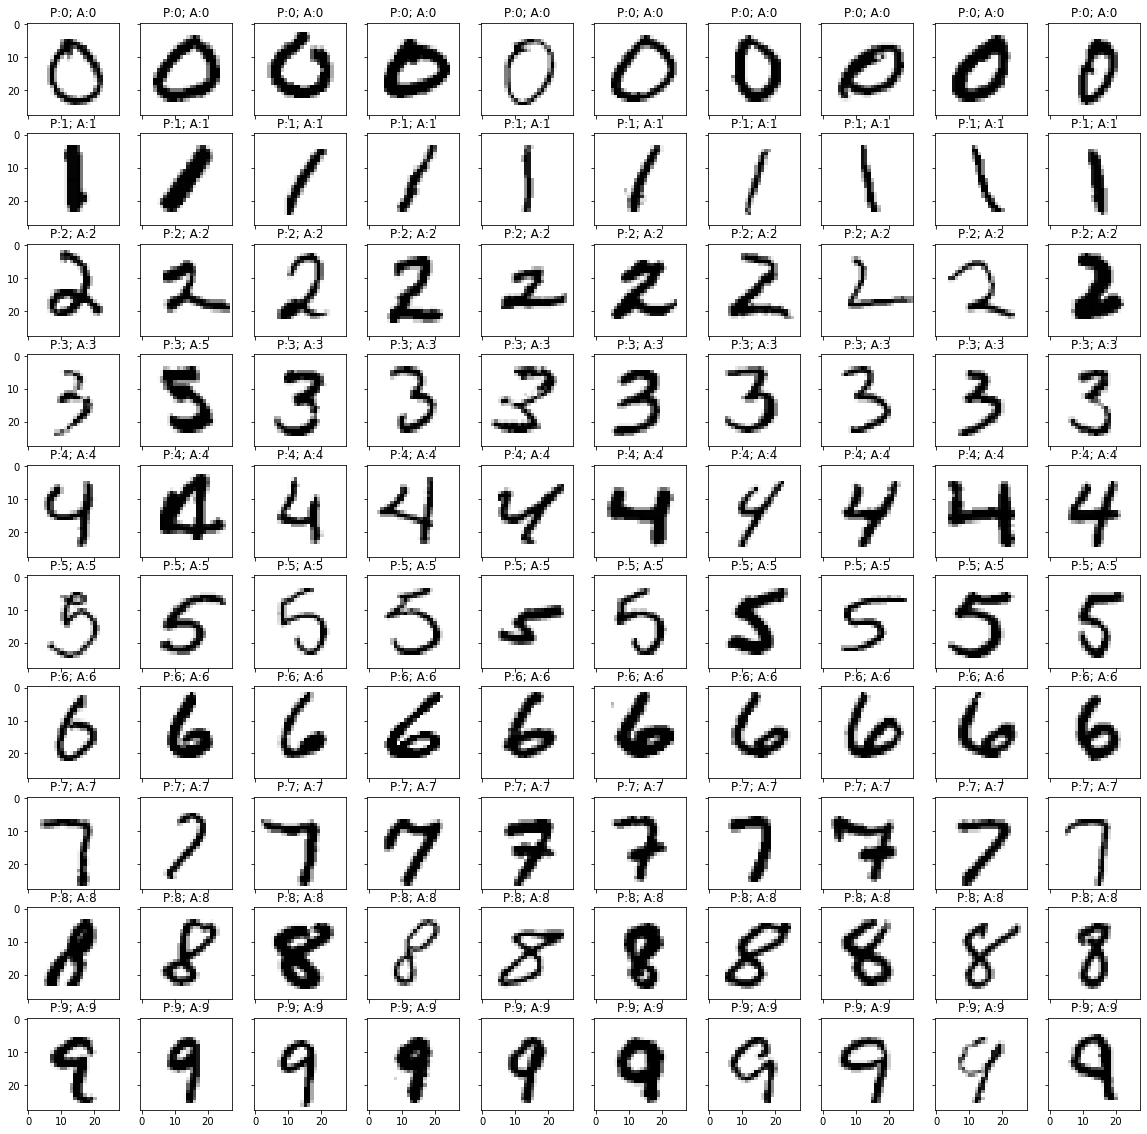

In [10]:
fig, axes = plt.subplots(10,10, 
                         figsize=(20,20),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect='equal'))
for i in range(0,10):
  val_images_curr = val_images[np.where(val_labels_pred==i),:,:].reshape([np.sum(val_labels_pred==i),input_dm1,input_dm2])
  val_labels_curr = val_labels[np.where(val_labels_pred==i)]
  for j in range(0,10):
    ax = axes[i,j]
    # plot image on subplot
    img = val_images_curr[j]
    label = str(val_labels_curr[j].item())
    ax.imshow(img, cmap='gray_r')
    ax.set_title("P:"+str(i)+"; A:"+label)
plt.show()

## 1.4

In [11]:
#Defining neural network class which returns output of every layer
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(input_dm1*input_dm2, 1024)
        self.hidden_layer_1 = nn.Linear(1024, 1024)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.hidden_layer_4 = nn.Linear(1024, 1024)
        self.hidden_layer_5 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024, 10)
        self.dd = nn.Dropout(0.2)
        
    def forward(self, x):
      
        complete_output = dict()
        x = self.input_layer(x)
        x = F.relu(x)
        complete_output["input_layer"]=self.dd(x)
        x = complete_output["input_layer"]
        
        #5 hidden layers
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        complete_output["hidden_layer_1"]=self.dd(x)
        x = complete_output["hidden_layer_1"]
        
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        complete_output["hidden_layer_2"]=self.dd(x)
        x = complete_output["hidden_layer_2"]
        
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        complete_output["hidden_layer_3"]=self.dd(x)
        x = complete_output["hidden_layer_3"]
        
        x = self.hidden_layer_4(x)
        x = F.relu(x)
        complete_output["hidden_layer_4"]=self.dd(x)
        x = complete_output["hidden_layer_4"]
        
        x = self.hidden_layer_5(x)
        x = F.relu(x)
        complete_output["hidden_layer_5"]=self.dd(x)
        x = complete_output["hidden_layer_5"]
        
        
        x = self.output_layer(x)
        complete_output["output_layer"]=F.softmax(x, dim=1)
        x = complete_output["output_layer"]
        
        
        return(complete_output)
my_model2 = Network2().to(device)
my_model2.load_state_dict(best_model.state_dict())
val_images_reshaped = val_images.reshape(-1, input_dm1*input_dm2).to(device)


In [12]:
#Calculating output with activations of all layers
complete_output = my_model2.forward(val_images_reshaped)

h5_activations = complete_output["hidden_layer_5"]
h5_activations.shape

torch.Size([10000, 1024])

In [13]:
#Selecting random indices for a sample subset of 1000 images
sample_indices = np.random.choice(np.array(range(0,n_test)),1000,replace=False)

#Selecting 10 random dimensions out of 1024
random_dim = np.random.choice(np.array(range(0,1024)),10,replace=False)

#Creating 1000*10 output for second to last layer
h5_activations_sample = h5_activations[sample_indices,:][:,random_dim]

#Getting labels for the activations using softmax and argmax
h5_labels_pred = F.softmax(h5_activations_sample,dim=1).argmax(1).cpu().numpy()
print(h5_labels_pred.shape)
print(np.unique(h5_labels_pred,return_counts=True))

(1000,)
(array([0, 1, 2, 3, 7, 8]), array([356, 218, 164,  66,  30, 166]))


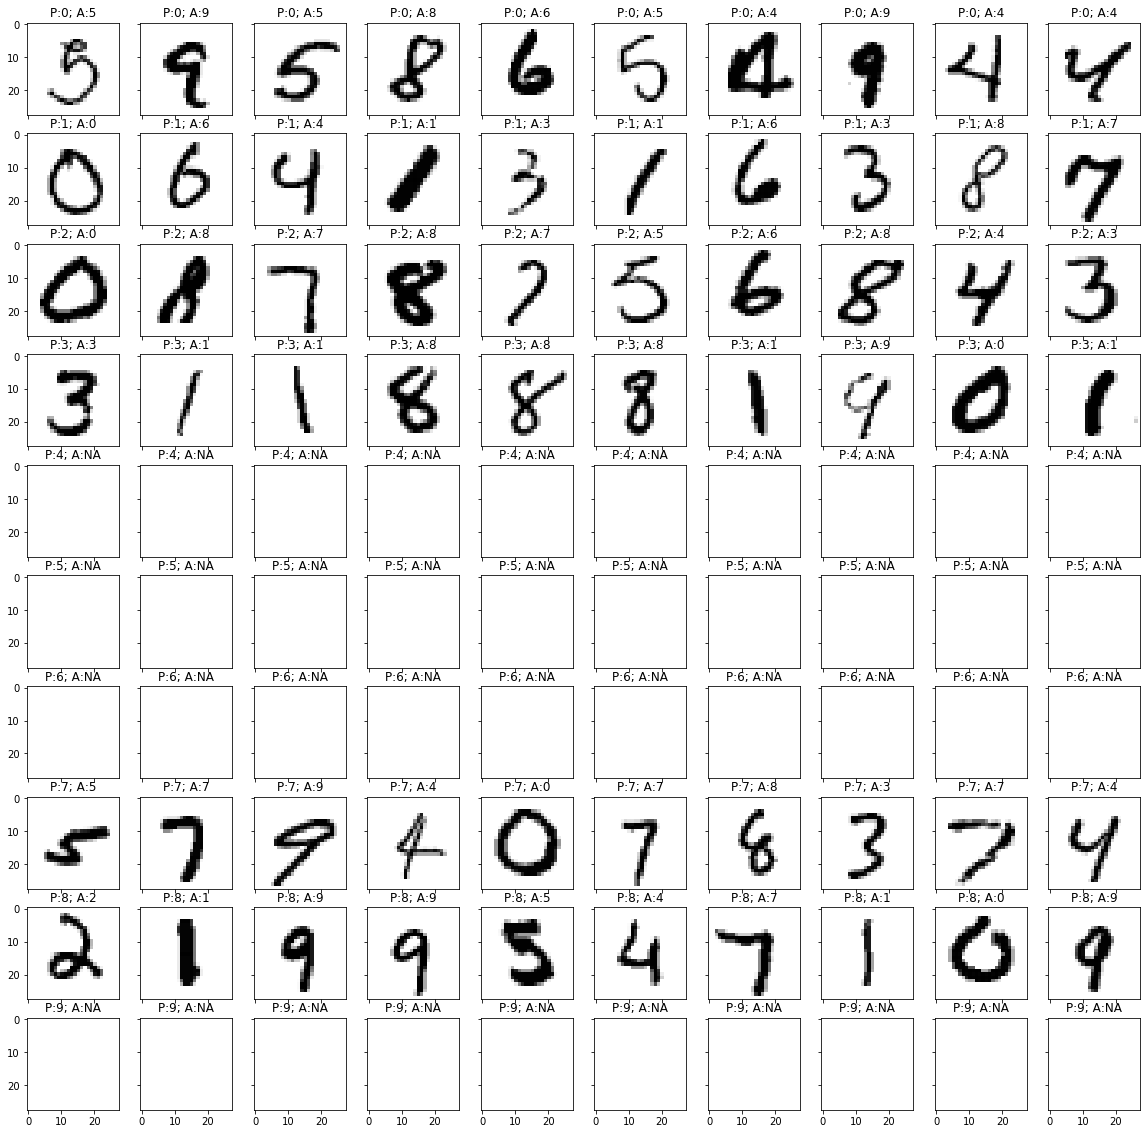

In [15]:
fig, axes = plt.subplots(10,10, 
                         figsize=(20,20),
                         sharex=True, sharey=True,
                         subplot_kw=dict( aspect='equal'))
for i in range(0,10):
  val_images_curr = val_images[np.where(h5_labels_pred==i),:,:].reshape([np.sum(h5_labels_pred==i),input_dm1,input_dm2])
  val_labels_curr = val_labels[np.where(h5_labels_pred==i)]
  for j in range(0,10):
    ax = axes[i,j]
    # plot image on subplot
    try:
      img = val_images_curr[j]
      label = str(val_labels_curr[j].item())
    except:
      img = np.zeros((input_dm1,input_dm2))
      label = "NA"
    ax.imshow(img, cmap='gray_r')
    
    ax.set_title("P:"+str(i)+"; A:"+label)
plt.show()

### Explanation:
We see that when the activations of second to last layer are converted to logits, they barely cover all the unique cases. Thus in the predicted labels(going by this layer), there are no prediction for certain digits at all, thus giving us blank images as set by the try and except logic. 
This is because the activations alone are just potential features that help determining the probability of each digit, and these activations haven't been trained to give us the corrct labels. Only the final layer output is trained against that, while the activations of this layer has been trained to give a suitable input to the last layer, ie useful features that a single layer neural network or logistic regression might most benefit from. If we changed the loss function so that we do indeed get such activations we might see similar result as 1.3.

## 1.5

### Transformation on actual images

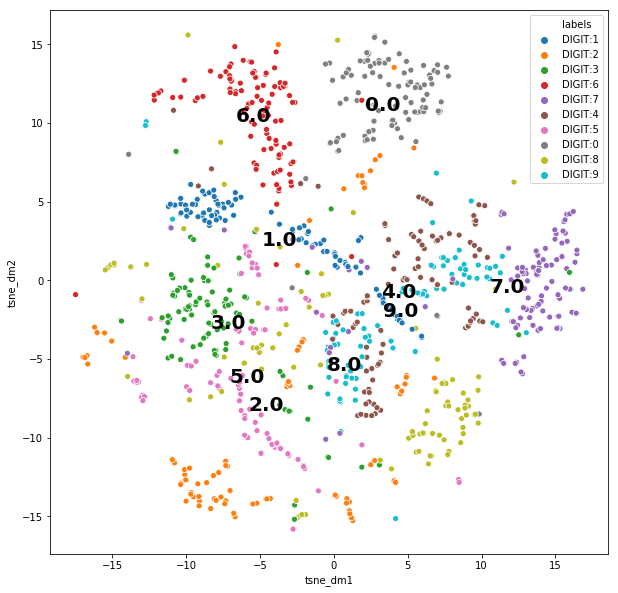

In [0]:
from sklearn.manifold import TSNE

#Getting 1000 random samples from the validation dataset
val_images_sample = val_images[sample_indices]
val_labels_sample = val_labels[sample_indices]

#Applying TSNE transformation
val_images_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(val_images_sample.reshape([1000,input_dm1*input_dm2]))

tsne_df = pd.DataFrame(val_images_tsne)
tsne_df.columns = ["tsne_dm1","tsne_dm2"]
tsne_df["labels"] = val_labels_sample.numpy()
tsne_df["labels"] = tsne_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
tsne_df_centroid = tsne_df.groupby("labels").agg({"tsne_dm1":"mean","tsne_dm2":"mean"}).reset_index()
tsne_df_centroid["labels"] = tsne_df_centroid["labels"].apply(lambda x:int(x[-1]))
tsne_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne_dm1",y="tsne_dm2",hue="labels",data=tsne_df)
centroid_vals = tsne_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

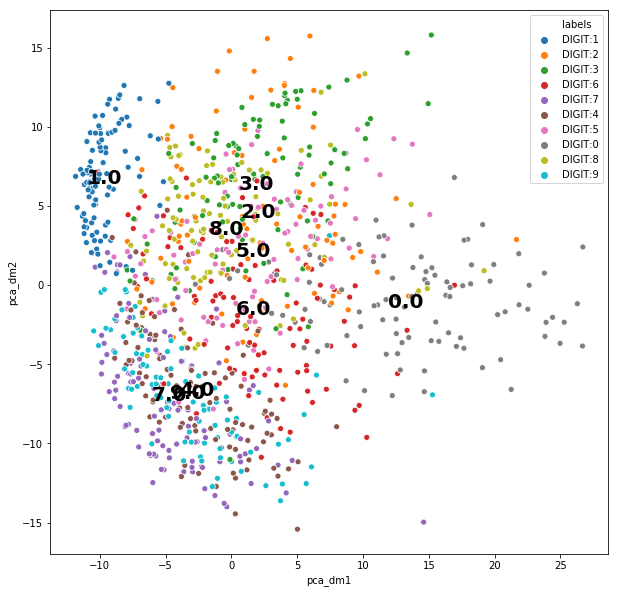

In [0]:
from sklearn.decomposition import PCA


#Applying pca transformation
val_images_pca = PCA(n_components=2).fit_transform(val_images_sample.reshape([1000,input_dm1*input_dm2]))

pca_df = pd.DataFrame(val_images_pca)
pca_df.columns = ["pca_dm1","pca_dm2"]
pca_df["labels"] = val_labels_sample.numpy()
pca_df["labels"] = pca_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
pca_df_centroid = pca_df.groupby("labels").agg({"pca_dm1":"mean","pca_dm2":"mean"}).reset_index()
pca_df_centroid["labels"] = pca_df_centroid["labels"].apply(lambda x:int(x[-1]))
pca_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="pca_dm1",y="pca_dm2",hue="labels",data=pca_df)
centroid_vals = pca_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

### Transformation on first hidden layer

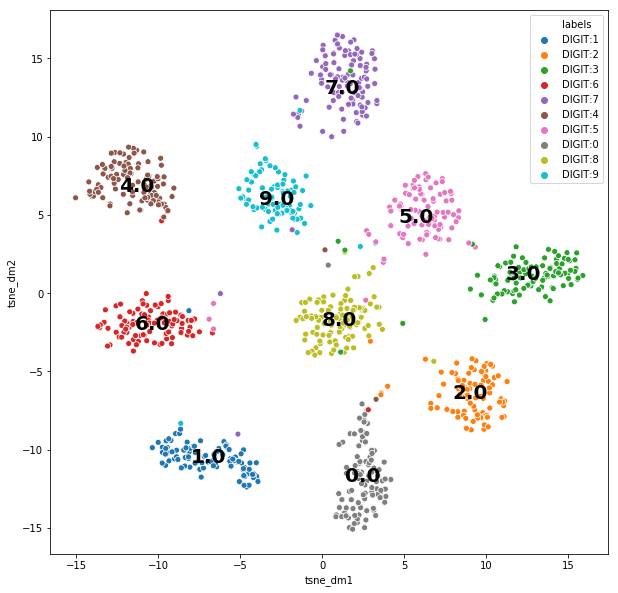

In [0]:
#Getting 1000 random samples from the layer
h1_activations = complete_output["hidden_layer_1"]
h1_activations_sample = h1_activations[sample_indices,:].detach().cpu().numpy()

#Applying TSNE transformation
val_images_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(h1_activations_sample.reshape([1000,1024]))

tsne_df = pd.DataFrame(val_images_tsne)
tsne_df.columns = ["tsne_dm1","tsne_dm2"]
tsne_df["labels"] = val_labels_sample.numpy()
tsne_df["labels"] = tsne_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
tsne_df_centroid = tsne_df.groupby("labels").agg({"tsne_dm1":"mean","tsne_dm2":"mean"}).reset_index()
tsne_df_centroid["labels"] = tsne_df_centroid["labels"].apply(lambda x:int(x[-1]))
tsne_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne_dm1",y="tsne_dm2",hue="labels",data=tsne_df)
centroid_vals = tsne_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

In [0]:
#Applying pca transformation
val_images_pca = PCA(n_components=2).fit_transform(h1_activations_sample.reshape([1000,1024]))

pca_df = pd.DataFrame(val_images_pca)
pca_df.columns = ["pca_dm1","pca_dm2"]
pca_df["labels"] = val_labels_sample.numpy()
pca_df["labels"] = pca_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
pca_df_centroid = pca_df.groupby("labels").agg({"pca_dm1":"mean","pca_dm2":"mean"}).reset_index()
pca_df_centroid["labels"] = pca_df_centroid["labels"].apply(lambda x:int(x[-1]))
pca_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="pca_dm1",y="pca_dm2",hue="labels",data=pca_df)
centroid_vals = pca_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

### Transformation on second hidden layer

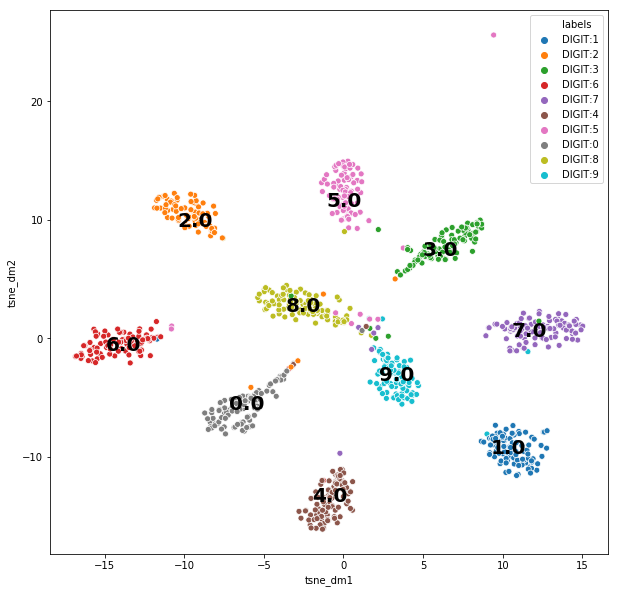

In [0]:
#Getting 1000 random samples from the layer
h2_activations = complete_output["hidden_layer_2"]
h2_activations_sample = h2_activations[sample_indices,:].detach().cpu().numpy()

#Applying TSNE transformation
val_images_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(h2_activations_sample.reshape([1000,1024]))

tsne_df = pd.DataFrame(val_images_tsne)
tsne_df.columns = ["tsne_dm1","tsne_dm2"]
tsne_df["labels"] = val_labels_sample.numpy()
tsne_df["labels"] = tsne_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
tsne_df_centroid = tsne_df.groupby("labels").agg({"tsne_dm1":"mean","tsne_dm2":"mean"}).reset_index()
tsne_df_centroid["labels"] = tsne_df_centroid["labels"].apply(lambda x:int(x[-1]))
tsne_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne_dm1",y="tsne_dm2",hue="labels",data=tsne_df)
centroid_vals = tsne_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

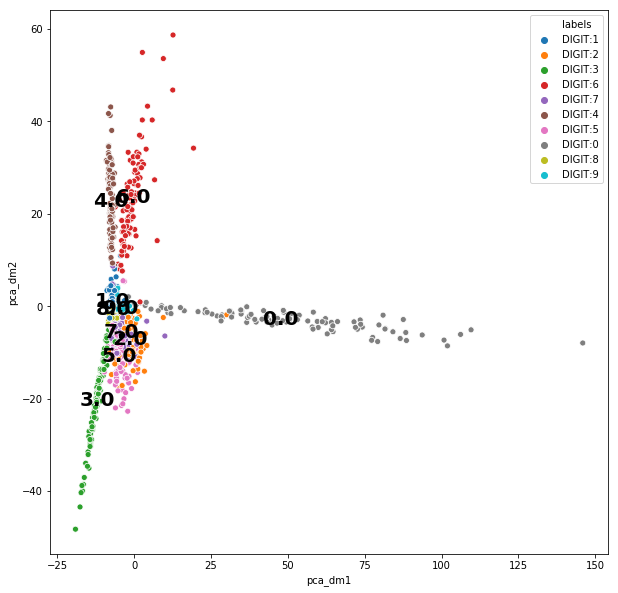

In [0]:
#Applying pca transformation
val_images_pca = PCA(n_components=2).fit_transform(h2_activations_sample.reshape([1000,1024]))

pca_df = pd.DataFrame(val_images_pca)
pca_df.columns = ["pca_dm1","pca_dm2"]
pca_df["labels"] = val_labels_sample.numpy()
pca_df["labels"] = pca_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
pca_df_centroid = pca_df.groupby("labels").agg({"pca_dm1":"mean","pca_dm2":"mean"}).reset_index()
pca_df_centroid["labels"] = pca_df_centroid["labels"].apply(lambda x:int(x[-1]))
pca_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="pca_dm1",y="pca_dm2",hue="labels",data=pca_df)
centroid_vals = pca_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

### Transformations on third hidden layer

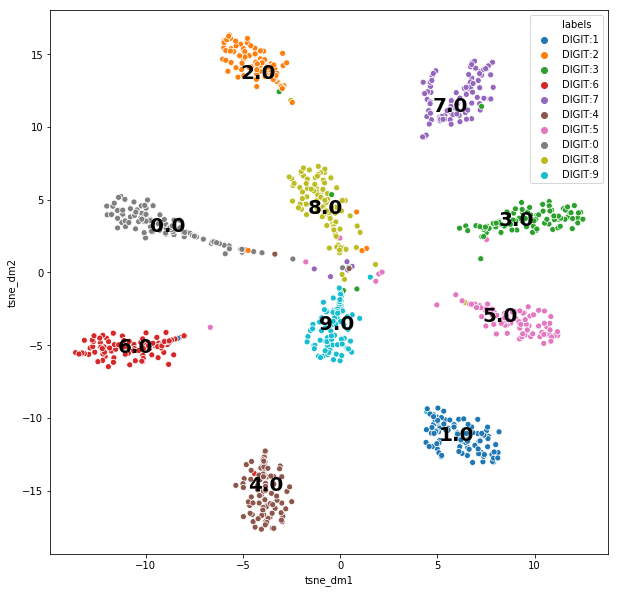

In [0]:
#Getting 1000 random samples from the layer
h3_activations = complete_output["hidden_layer_3"]
h3_activations_sample = h3_activations[sample_indices,:].detach().cpu().numpy()

#Applying TSNE transformation
val_images_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(h3_activations_sample.reshape([1000,1024]))

tsne_df = pd.DataFrame(val_images_tsne)
tsne_df.columns = ["tsne_dm1","tsne_dm2"]
tsne_df["labels"] = val_labels_sample.numpy()
tsne_df["labels"] = tsne_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
tsne_df_centroid = tsne_df.groupby("labels").agg({"tsne_dm1":"mean","tsne_dm2":"mean"}).reset_index()
tsne_df_centroid["labels"] = tsne_df_centroid["labels"].apply(lambda x:int(x[-1]))
tsne_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne_dm1",y="tsne_dm2",hue="labels",data=tsne_df)
centroid_vals = tsne_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

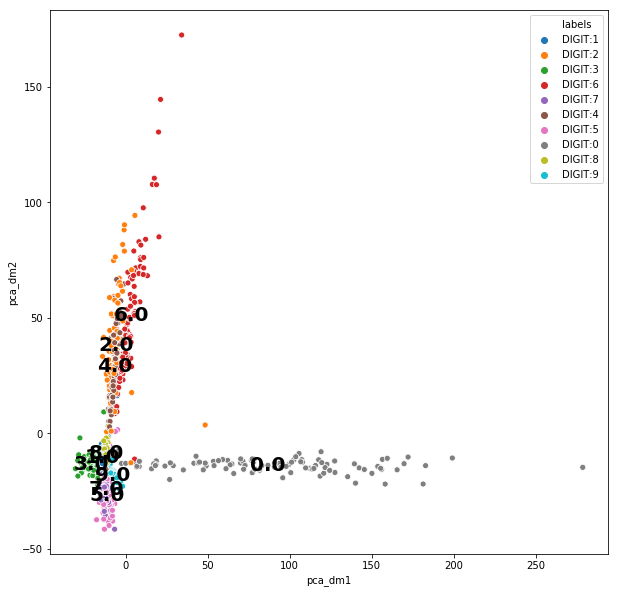

In [0]:
#Applying pca transformation
val_images_pca = PCA(n_components=2).fit_transform(h3_activations_sample.reshape([1000,1024]))

pca_df = pd.DataFrame(val_images_pca)
pca_df.columns = ["pca_dm1","pca_dm2"]
pca_df["labels"] = val_labels_sample.numpy()
pca_df["labels"] = pca_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
pca_df_centroid = pca_df.groupby("labels").agg({"pca_dm1":"mean","pca_dm2":"mean"}).reset_index()
pca_df_centroid["labels"] = pca_df_centroid["labels"].apply(lambda x:int(x[-1]))
pca_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="pca_dm1",y="pca_dm2",hue="labels",data=pca_df)
centroid_vals = pca_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

### Transformation on fourth hidden layer

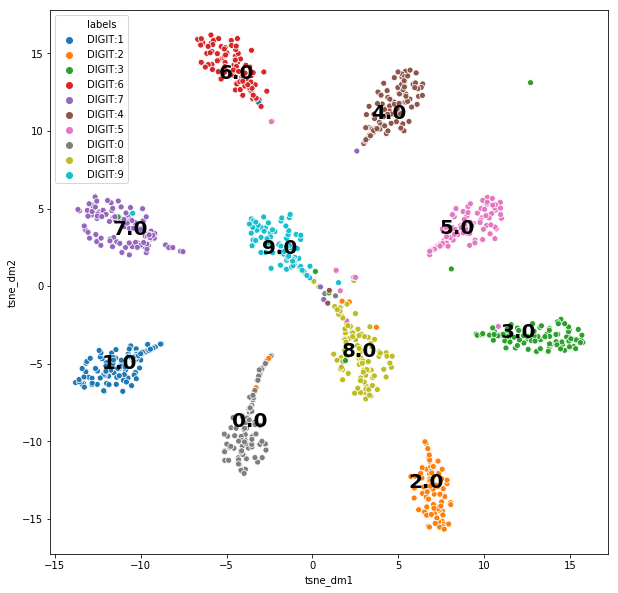

In [0]:
#Getting 1000 random samples from the layer
h4_activations = complete_output["hidden_layer_4"]
h4_activations_sample = h4_activations[sample_indices,:].detach().cpu().numpy()

#Applying TSNE transformation
val_images_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(h4_activations_sample.reshape([1000,1024]))

tsne_df = pd.DataFrame(val_images_tsne)
tsne_df.columns = ["tsne_dm1","tsne_dm2"]
tsne_df["labels"] = val_labels_sample.numpy()
tsne_df["labels"] = tsne_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
tsne_df_centroid = tsne_df.groupby("labels").agg({"tsne_dm1":"mean","tsne_dm2":"mean"}).reset_index()
tsne_df_centroid["labels"] = tsne_df_centroid["labels"].apply(lambda x:int(x[-1]))
tsne_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne_dm1",y="tsne_dm2",hue="labels",data=tsne_df)
centroid_vals = tsne_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

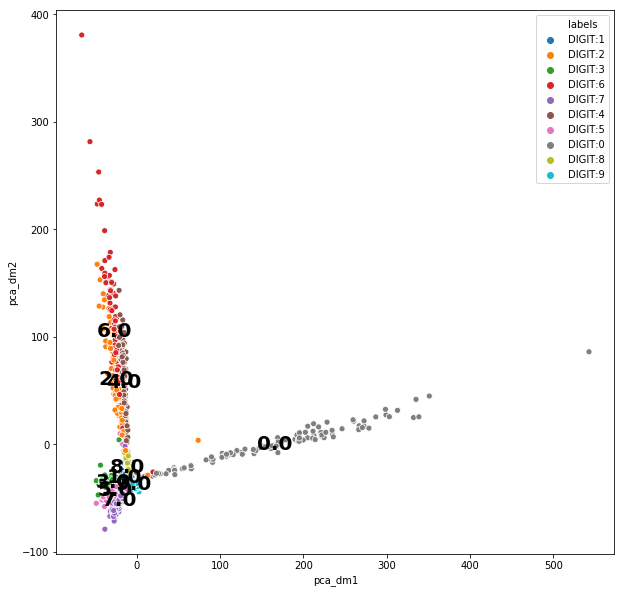

In [0]:
#Applying pca transformation
val_images_pca = PCA(n_components=2).fit_transform(h4_activations_sample.reshape([1000,1024]))

pca_df = pd.DataFrame(val_images_pca)
pca_df.columns = ["pca_dm1","pca_dm2"]
pca_df["labels"] = val_labels_sample.numpy()
pca_df["labels"] = pca_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
pca_df_centroid = pca_df.groupby("labels").agg({"pca_dm1":"mean","pca_dm2":"mean"}).reset_index()
pca_df_centroid["labels"] = pca_df_centroid["labels"].apply(lambda x:int(x[-1]))
pca_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="pca_dm1",y="pca_dm2",hue="labels",data=pca_df)
centroid_vals = pca_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

### Transformations on fifth hidden layer

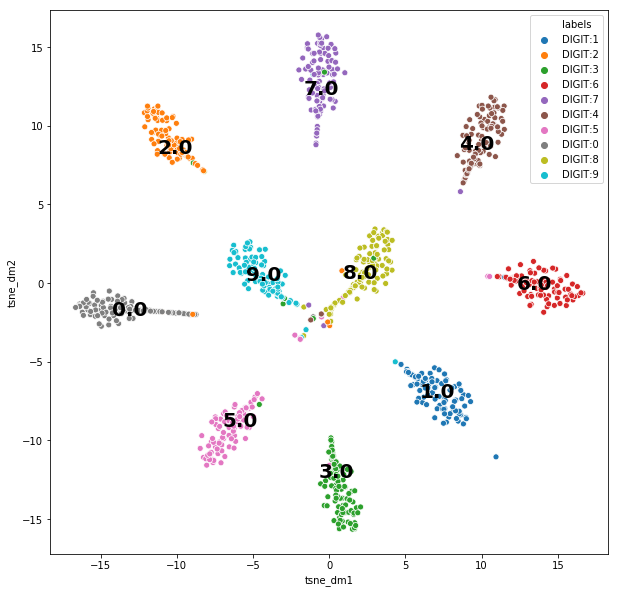

In [0]:
#Getting 1000 random samples from the layer
h5_activations = complete_output["hidden_layer_5"]
h5_activations_sample = h5_activations[sample_indices,:].detach().cpu().numpy()

#Applying TSNE transformation
val_images_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(h5_activations_sample.reshape([1000,1024]))

tsne_df = pd.DataFrame(val_images_tsne)
tsne_df.columns = ["tsne_dm1","tsne_dm2"]
tsne_df["labels"] = val_labels_sample.numpy()
tsne_df["labels"] = tsne_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
tsne_df_centroid = tsne_df.groupby("labels").agg({"tsne_dm1":"mean","tsne_dm2":"mean"}).reset_index()
tsne_df_centroid["labels"] = tsne_df_centroid["labels"].apply(lambda x:int(x[-1]))
tsne_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne_dm1",y="tsne_dm2",hue="labels",data=tsne_df)
centroid_vals = tsne_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

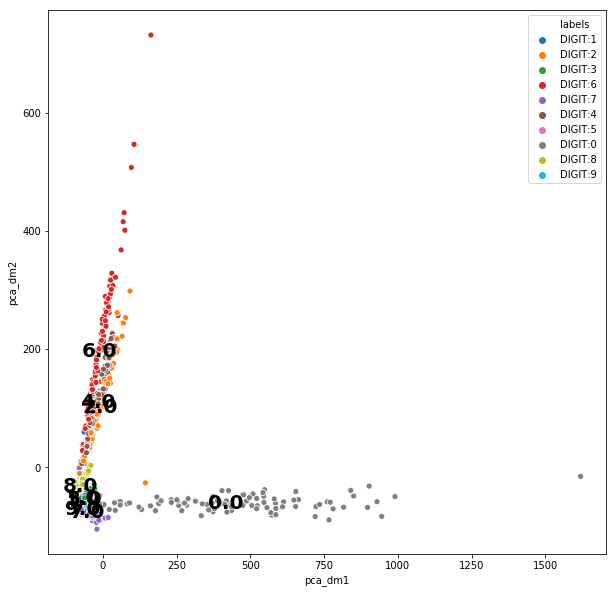

In [0]:
#Applying pca transformation
val_images_pca = PCA(n_components=2).fit_transform(h5_activations_sample.reshape([1000,1024]))

pca_df = pd.DataFrame(val_images_pca)
pca_df.columns = ["pca_dm1","pca_dm2"]
pca_df["labels"] = val_labels_sample.numpy()
pca_df["labels"] = pca_df["labels"].apply(lambda x:"DIGIT:"+str(x))

#Getting centroid of each label
pca_df_centroid = pca_df.groupby("labels").agg({"pca_dm1":"mean","pca_dm2":"mean"}).reset_index()
pca_df_centroid["labels"] = pca_df_centroid["labels"].apply(lambda x:int(x[-1]))
pca_df_centroid.sort_values(by="labels",ascending=True,inplace=True)

plt.figure(figsize=(10,10))
sns.scatterplot(x="pca_dm1",y="pca_dm2",hue="labels",data=pca_df)
centroid_vals = pca_df_centroid.values
for i in range(0,10):
  plt.annotate(str(centroid_vals[i,0]), 
                 (centroid_vals[i,1],centroid_vals[i,2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold',
                 color='k')

### Explanation:



1.   We see that for the TSNE transformations for the subsequent layers, the sample with the same labels are much more clustered and these clusters are seperated and definable.
2.   This is because as the neural network is trained the activation values are trained to be significant features relevant to the classification labels. It also filters out the noise among the layers so that the 1024 dimensions now contain information only relevant to the label of the sample and other information is nullified.



# Problem 2

## 2.1-2.7

In [0]:
s, sr=librosa.load("train_clean_male.wav", sr=None)
S_complex=stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load("train_dirty_male.wav", sr=None)
X_complex=stft(sn, n_fft=1024, hop_length=512)

input_dm = X_complex.shape[0]
n_train = X_complex.shape[1]
X_complex = X_complex.reshape([n_train,input_dm])
S_complex = S_complex.reshape([n_train,input_dm])

print(X_complex.shape)
print(S_complex.shape)

X = np.abs(X_complex)
S = np.abs(S_complex)
X = torch.tensor(X).to(device)
S = torch.tensor(S).to(device)

(2459, 513)
(2459, 513)


## 2.8

In [0]:
class Sound_Network(nn.Module):
    def __init__(self,dropout,input_dm):
        super(Sound_Network,self).__init__()
        self.input_layer = nn.Linear(input_dm, 1024)
        self.hidden_layer_1 = nn.Linear(1024, 1024)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.output_layer = nn.Linear(1024,input_dm)
        self.dd = nn.Dropout(dropout)
        
    def forward(self, x):
        
        x = self.input_layer(x)
        x = F.relu(x)
        x = self.dd(x)
        
        #hidden layers
        x = self.hidden_layer_1(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.hidden_layer_2(x)
        x = F.relu(x)
        x = self.dd(x)
        x = self.hidden_layer_3(x)
        x = F.relu(x)
        x = self.dd(x)
        
        x = self.output_layer(x)
        x = F.relu(x)
        
        return x

def weights_init_uniform_rule(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model..
  if classname.find('Linear') != -1:
      # get the number of the inputs
      n = m.in_features
      y = 1.0/np.sqrt(n)
      m.weight.data.uniform_(-y, y)
      m.bias.data.fill_(0)

In [0]:
train_dataset = torch.utils.data.TensorDataset(X,S)


from sklearn.metrics import mean_squared_error
def neg_mean_squared_error(y_true,y_pred):
  return((-1)*(mean_squared_error(y_true,y_pred)))

#Defining hyper parameters 
batch_size = 300
dropout = 0.2
learning_rate = 0.001
epochs=200
early_stopping_rounds = 10

#Creating dataloader, in this case both train loader and val loader come from train dataset but only differ in batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=batch_size, 
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=n_train, 
                                         shuffle=True)

#Defining model object and applying initialization
denoising_model = Sound_Network(dropout=dropout,input_dm=input_dm).to(device)
denoising_model.apply(weights_init_uniform_rule)

Sound_Network(
  (input_layer): Linear(in_features=513, out_features=1024, bias=True)
  (hidden_layer_1): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer_2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer_3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=513, bias=True)
  (dd): Dropout(p=0.2, inplace=False)
)

In [0]:
# Optimizer
optimizer = torch.optim.Adam(denoising_model.parameters(), lr=learning_rate)


# Train the model
epoch=1
stop=0
best_performance = -1000000
rounds = 0
stop = False
verbose=True
criterion = nn.MSELoss()
verbose=True
eval_func = neg_mean_squared_error




#Training while loop 
if(verbose==True):
    print("Training commenced")
while ((epoch <= epochs)and(stop==False)):
    train_loss = 0
    for clips, clean_clips in train_loader:  
        # Move tensors to GPU/CPU
        clips_reshaped = clips.reshape([len(clips),input_dm]).to(device)
        clean_clips = clean_clips.reshape([len(clean_clips),input_dm]).to(device)

        # Forward pass
        outputs = denoising_model(clips)
        loss = criterion(outputs,clean_clips)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    with torch.no_grad():
        val_clips,val_clips_clean = next(iter(val_loader))
        val_clips_reshaped = val_clips.reshape([len(val_clips),input_dm]).to(device)
        val_clips_clean_pred = denoising_model.forward(val_clips_reshaped).detach().cpu().numpy()
        performance = eval_func(val_clips_clean.cpu().numpy(),val_clips_clean_pred)


    #Check if we have an increase in performance
    if(performance > best_performance):
        rounds = 0
        best_performance = performance
        best_prediction = val_clips_clean_pred
        best_state_dict = denoising_model.state_dict()
        best_denoising_model = denoising_model
    else:
        rounds += 1
        if(rounds == early_stopping_rounds):
            stop = True


    #Print statement, every 5 epochs or if it is the last epoch
    if(((epoch%5==0)|(stop==True))&(verbose==True)):
        print("EPOCH:"+str(epoch))
        if(stop==True):
            print("Training to be concluded after this epoch") 
        print("Average training loss per sample  = "+str(train_loss/n_train))
        print('Performance of the network in current epoch = '+str(round(performance,2)))
        print('Best performance of the network yet  = '+str(best_performance))


    epoch += 1
    #While loop ends

print("BEST SCORE IS:"+str(best_performance))

Training commenced
EPOCH:5
Average training loss per sample  = 0.0003048980600250208
Performance of the network in current epoch = -0.09
Best performance of the network yet  = -0.08617274463176727
EPOCH:10
Average training loss per sample  = 0.0003093143333478302
Performance of the network in current epoch = -0.08
Best performance of the network yet  = -0.08454854786396027
EPOCH:15
Average training loss per sample  = 0.0002748207494028703
Performance of the network in current epoch = -0.07
Best performance of the network yet  = -0.07203934341669083
EPOCH:20
Average training loss per sample  = 0.00025256379572246657
Performance of the network in current epoch = -0.06
Best performance of the network yet  = -0.06303614377975464
EPOCH:25
Average training loss per sample  = 0.00021197675034591656
Performance of the network in current epoch = -0.05
Best performance of the network yet  = -0.053637295961380005
EPOCH:30
Average training loss per sample  = 0.00018116006731453733
Performance of t

## 2.10-2.12

In [0]:
#Function to read input file, pass through our NN and get cleaned signal and then write it to .wav file
def get_clean_signal(input_filename,output_filename,denoising_model):
    t,sr=librosa.load(input_filename, sr=None)
    print(t.shape)
    X_test_complex=stft(t, n_fft=1024, hop_length=512)
    print(X_test_complex.shape)
    X_test_complex = X_test_complex.T
    print(X_test_complex.shape)
    X_test = torch.tensor(np.abs(X_test_complex)).to(device)
    S_test = denoising_model.forward(X_test)
    X_test_dir = np.divide(X_test_complex,X_test.cpu().numpy())
    S_test_complex = np.multiply(X_test_dir,S_test.detach().cpu().numpy())
    print(S_test_complex.shape)
    S_test_complex = S_test_complex.T
    print(S_test_complex.shape)
    s_test = istft(S_test_complex, hop_length=512)
    librosa.output.write_wav(output_filename,s_test,sr=sr)
    return

In [0]:
class same_answer(nn.Module):        
    def forward(self, x):
        return (x)
sanity_check = same_answer()

In [0]:
get_clean_signal("train_dirty_male.wav","train_sanity_check.wav",sanity_check)

(1258899,)
(513, 2459)
(2459, 513)
(2459, 513)
(513, 2459)


In [0]:
get_clean_signal("train_dirty_male.wav","train_clean_pred.wav",best_denoising_model)

In [0]:
get_clean_signal("test_x_01.wav","test_x_01_cleaned.wav",best_denoising_model)

In [0]:
get_clean_signal("test_x_02.wav","test_x_02_cleaned.wav",best_denoising_model)